# Faktorska analiza akademskih rezultata učenika srednjih škola

Akademske performanse općenito se definiraju kao razina do koje je određeni učenik/učenica postigao svoje kratkoročne ili dugoročne akademske ciljeve. Iste se najčešće mjere usmenim i/ili pismenim ispitima kao i kontinuiranim provjerama znanja koje naposljetku rezultiraju metrikama poput težinskih prosjeka ocjena ili rezultata standardiziranih testova sposobnosti. Pitanje intrizičnog značaja za ovo područje istraživanja pronalazak je, odnosno definiranje faktora koji uspješno mogu predvidjeti učenikove akademske performase, poput razine edukacije roditelja, motivacije učenika, socioekonomske pozadine itd. Iako rezultati studija nisu konkluzivni, određeni faktori poput inteligencije učenika mjerene standardiziranim IQ testovima ili samodiscipline povezane su s razlikama u akademskim performansama. Također, prema određenim, iako i dalje nekonkluzivnim studijama, utjecaj roditelja može objasniti i do 80% akademskog uspjeha djeteta. Glavni je cilj ove podatkovne analize **istražiti vezu raznih faktora (osobni, ekonomski, socijalni) i akademskog uspjeha učenika**. Rezultati istraživanja imaju važne praktične posljedice i mogu potencijalno imati značaj u smislu poduzimanja akcija s ciljem maksimizacije akademskog uspjeha učenika i smanjenja razine psihološkog stresa tijekom školovanja.
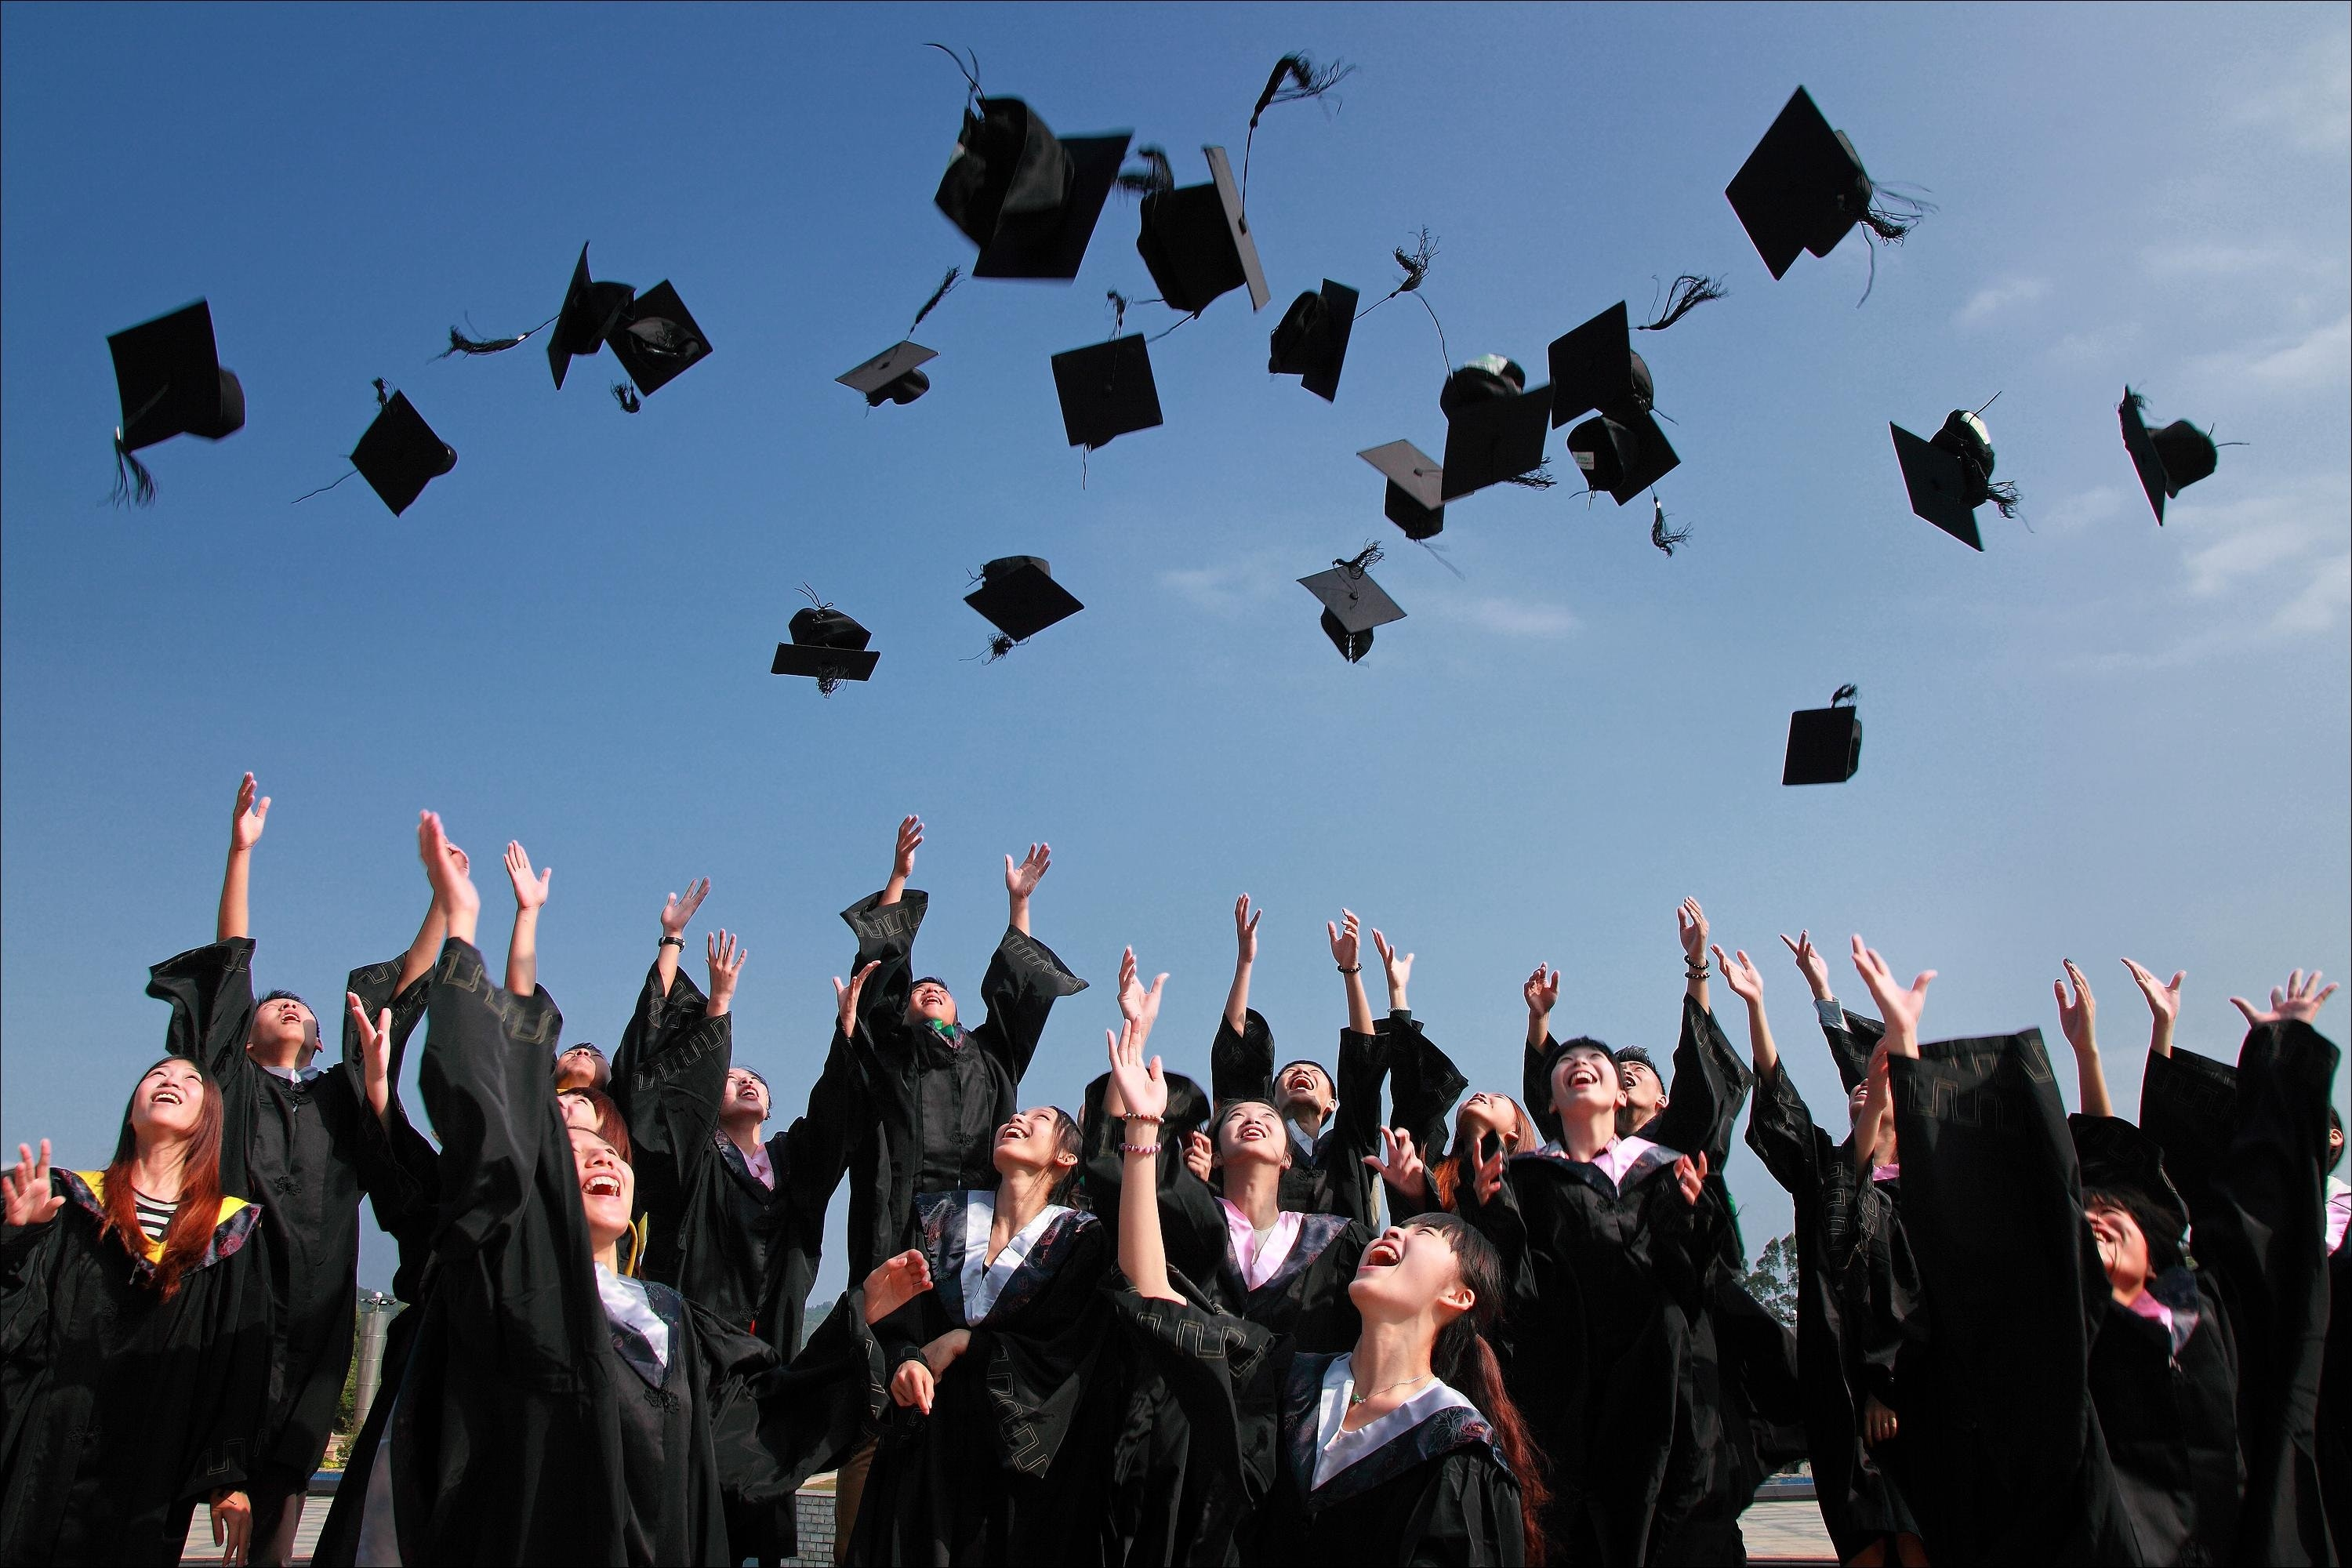
*Slika 1: Maturantska proslava. Postizanje obrazovnih "benchmark"-ova poput završetka srednje škole (prikazano na slici) ili završetka fakulteta smatraju se osnovnim primjerom akademskog uspjeha*

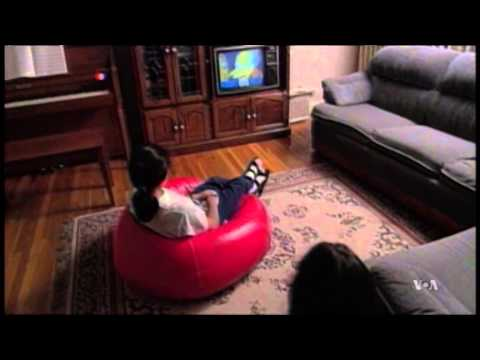

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("g8sL-x4DbqY")

*Video 1: Studija o utjecaju fizičkog dobrostanja na akademske performanse, prilog VoA News. Jedna u nizu od studija unutar područja istraživanja kojemu je primarni cilj odrediti faktore u kauzalnoj vezi s akademskim performansama*
***

## 1. Eksplorativna analiza podataka

Podatkovni skup korišten za potrebe ove analize nalazi se na __[web stranici](http://roycekimmons.com/)__ docenta Roycea Kimmonsa, PhD, čije područje istraživanja uključuje otvorenu edukaciju te korištenje napredne tehnologije u nastavi. Analizu započinjemo importiranjem svih potrebnih paketa, odnosno funkcija.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from urllib.request import urlretrieve
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot
%matplotlib inline

U svrhu mijenjanja načina ispisa DataFrame struktura učitavamo CSS datoteku s definiranim željenim izgledom.

In [3]:
from IPython.core.display import HTML
css = open("custom.css", "r").read()
HTML("<style>{}</style>".format(css))

Zatim pristupamo podatkovnom skupu korištenjem funkcije get_data().

In [4]:
URL = "http://roycekimmons.com/system/generate_data.php?dataset=exams&n=1000"

def get_data(filename="stdata.csv", url=URL, force_download=False):
    if force_download or not os.path.exists(filename):
        urlretrieve(url, filename)
    data = pd.read_csv("stdata.csv")
    return data

In [5]:
data = get_data()

Koristimo metodu pd.head() (s defaultnim parametrom $5$) s ciljem stjecanja krupne slike o podatkovnom skupu.

In [6]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,master's degree,standard,none,85,81,82
1,male,group B,some college,free/reduced,none,64,61,49
2,female,group E,high school,free/reduced,none,48,52,53
3,male,group C,bachelor's degree,standard,completed,85,85,80
4,female,group C,associate's degree,standard,none,74,82,79


Vidljivo je kako naš podatkovni skup sadrži sljedeće značajke: spol, rasa/narodnost, razina obrazovanja roditelja, ručak, pripremni tečaj za test te rezultati ispita iz matematike, čitanja i pisanja. U tablici se ne nalaze eksplicitni nazivi za određene rase/narodnosti već samo slova od A do E kao oznake. Varijabla "lunch" posebno je zanimljiva te govori o tome jede li učenik standardni školski ručak ili reducirani/besplatni, što govori o ekonomskom statusu učenika. U sljedećem koraku određujemo duljinu i oblik skupa.

In [7]:
print(len(data))
print(data.shape)

1000
(1000, 8)


Prosjeke, standardne devijacije, percentile i ostala obilježja određenih značajki našeg podatkovnog skupa određujemo korištenjem metode pd.df.describe() te provjeravamo tip podatka za svaki stupac pomoću atributa pd.df.dtypes.

In [8]:
data.describe()

,math score,reading score,writing score
count,1000.000000,1000.000000,1000.000000
mean,67.003000,69.901000,68.676000
std,14.740022,14.335505,14.873273
min,18.000000,27.000000,22.000000
25%,57.000000,60.000000,59.000000
50%,66.500000,70.000000,69.000000
75%,78.000000,80.000000,80.000000
max,100.000000,100.000000,100.000000


In [9]:
data.dtypes

gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object

Primijetimo da je podatkovni tip za prvih pet stupaca "object", odnosno "int64" za rezultate iz matematike, čitanja i pisanja. Nadalje, korisno je provjeriti postoje li "NULL" vrijednosti u našem podatkovnom skupu.

In [10]:
data.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

Zaključujemo da nema "NULL" vrijednosti. Nadalje, određujemo koje vrijednosti poprima prvih pet stupaca (kategoričke varijable):

In [11]:
for y in [x for x in data.columns][:5]:
    print(data[y].unique())

['male' 'female']
['group A' 'group B' 'group E' 'group C' 'group D']
["master's degree" 'some college' 'high school' "bachelor's degree"
 "associate's degree" 'some high school']
['standard' 'free/reduced']
['none' 'completed']


Vizualizirajmo najprije rezultate iz matematike, čitanja i pisanja uporabom paketa *seaborn* te istražimo koje su prosječne vrijednosti.

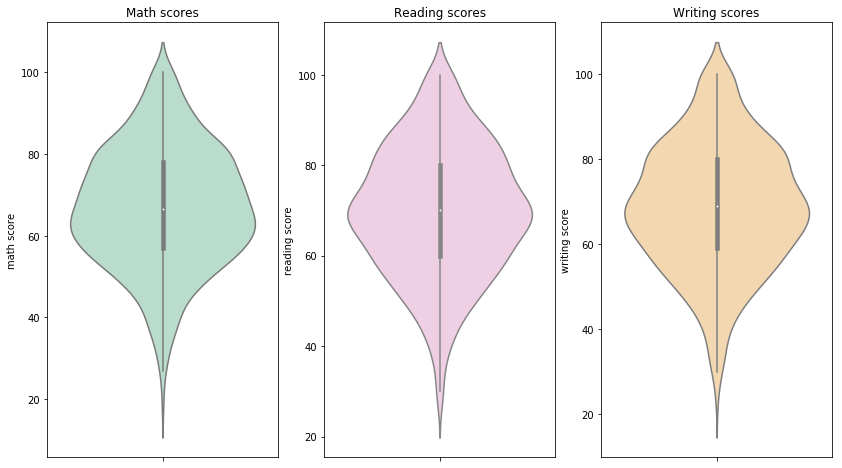

In [12]:
plt.figure(figsize=(24,8))

plt.subplot(1, 5, 1)
plt.title("Math scores")
sns.violinplot(y="math score",data=data,palette="Pastel2")

plt.subplot(1, 5, 2)
plt.title("Reading scores")
sns.violinplot(y="reading score",data=data,palette="Pastel2_r")

plt.subplot(1, 5, 3)
plt.title("Writing scores")
sns.violinplot(y="writing score",data=data,palette="Pastel1_r")
plt.show()

In [13]:
print("Prosječan rezultat iz matematike je    : {}".format(np.mean(data["math score"])))
print("Prosječan rezultat iz čitanja je : {}".format(np.mean(data["reading score"])))
print("Prosječan rezultat iz pisanja je : {}".format(np.mean(data["writing score"])))

Prosječan rezultat iz matematike je    : 67.003
Prosječan rezultat iz čitanja je : 69.901
Prosječan rezultat iz pisanja je : 68.676


Iz grafa je vidljivo da većina studenata ostvaruje rezultat u rasponu od 40 do 90 bodova za svako od područja. Zatim određujemo korelacijsku matricu za značajke rezultata iz matematike, čitanja i pisanja.

In [14]:
data.corr()

,math score,reading score,writing score
math score,1.000000,0.826627,0.803143
reading score,0.826627,1.000000,0.950016
writing score,0.803143,0.950016,1.000000


Možemo primijetiti visoku korelaciju, koja je iznad 81% za svaku kombinaciju značajki rezultata. Navedeno dodatno potvrđujemo korištenjem sns.pairplot() i sns.heatmap().

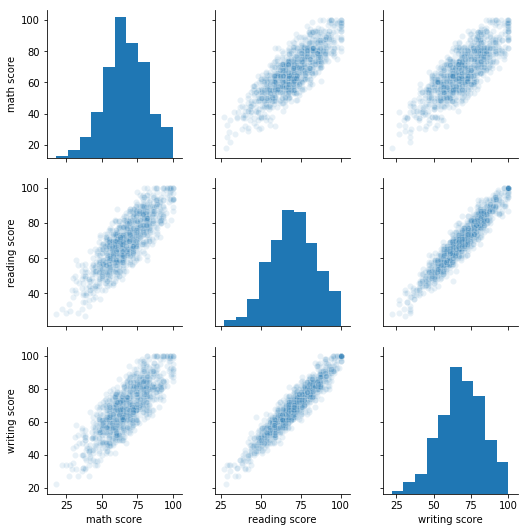

In [15]:
sns.pairplot(data=data, plot_kws={"alpha":0.1})

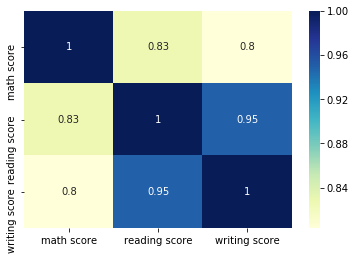

In [16]:
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
plt.show()

Prije nastavka analize uvodimo dodatan stupac "total score", koji sadrži ukupan rezultat, odnosno zbroj pojedinačnih rezultata iz matematike, čitanja i pisanja.

In [17]:
data["total score"]=data["math score"]+data["reading score"]+data["writing score"]
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score
0,male,group A,master's degree,standard,none,85,81,82,248
1,male,group B,some college,free/reduced,none,64,61,49,174
2,female,group E,high school,free/reduced,none,48,52,53,153
3,male,group C,bachelor's degree,standard,completed,85,85,80,250
4,female,group C,associate's degree,standard,none,74,82,79,235


Obzirom da nas interesira utjecaj pojedinih značajki na rezultate, u nastavku vizualiziramo navedeno korištenjem *seaborn* paketa.

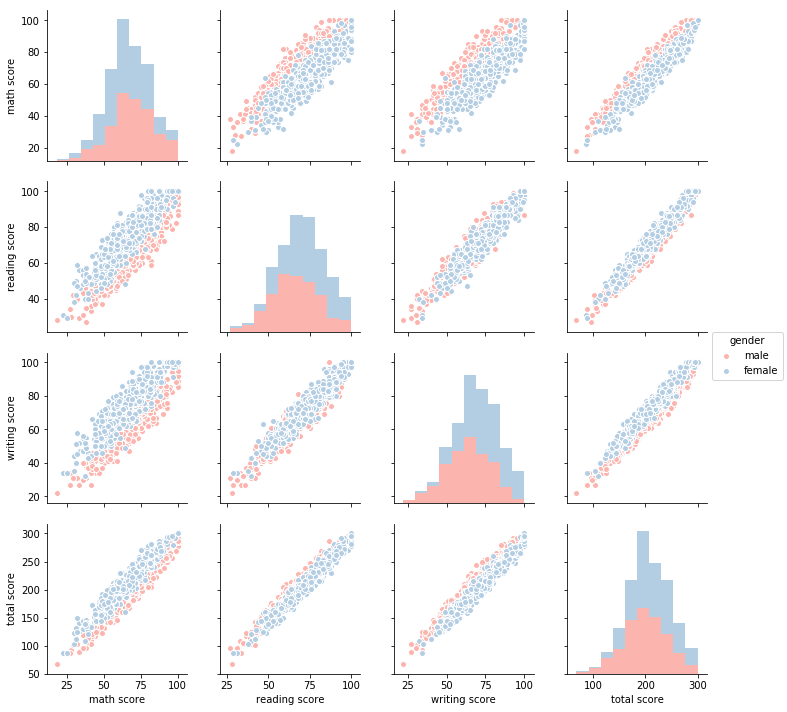

In [18]:
sns.pairplot(data, hue = "gender", palette="Pastel1")
plt.show()

Iz gornjih je grafova vidljivo da učenice u odnosu na učenike u prosjeku postižu bolje rezultate u čitanju i pisanju, ali slabije iz matematike. U nastavku koristimo barplotove i boxplotove za vizualizaciju veze između raznih značajki i rezultata iz matematike, čitanja i pisanja.

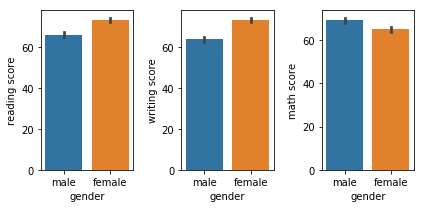

In [19]:
plt.figure(figsize=(6,3))

plt.subplot(1,3,1)
sns.barplot(x="gender", y ="reading score", data = data)

plt.subplot(1,3,2)
sns.barplot(x="gender", y ="writing score", data = data)

plt.subplot(1,3,3)
sns.barplot(x="gender", y ="math score", data = data)

plt.tight_layout()

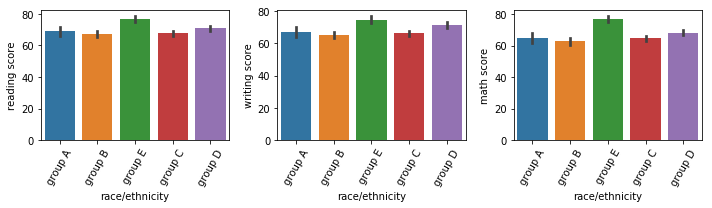

In [20]:
plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
sns.barplot(x="race/ethnicity", y="reading score", data = data)
plt.xticks(rotation = 60)

plt.subplot(1,3,2)
sns.barplot(x="race/ethnicity", y="writing score", data = data)
plt.xticks(rotation = 60)

plt.subplot(1,3,3)
sns.barplot(x="race/ethnicity", y="math score", data = data)
plt.xticks(rotation = 60)

plt.tight_layout()

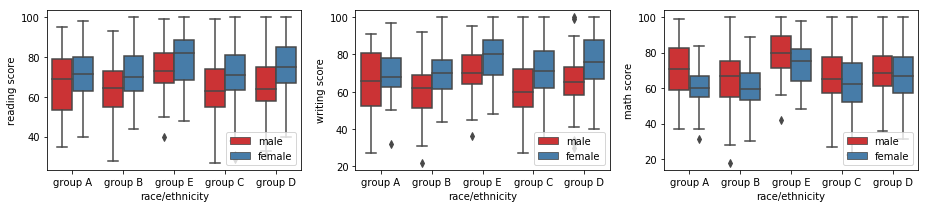

In [21]:
plt.figure(figsize=(13,3))

plt.subplot(1,3,1)
sns.boxplot(x=data["race/ethnicity"], y=data["reading score"], hue=data["gender"], palette="Set1")
plt.legend(loc='lower right')

plt.subplot(1,3,2)
sns.boxplot(x=data["race/ethnicity"], y=data["writing score"], hue=data["gender"], palette="Set1")
plt.legend(loc="lower right")

plt.subplot(1,3,3)
sns.boxplot(x=data["race/ethnicity"], y=data["math score"], hue=data["gender"], palette="Set1")
plt.legend(loc="lower right")

plt.tight_layout()

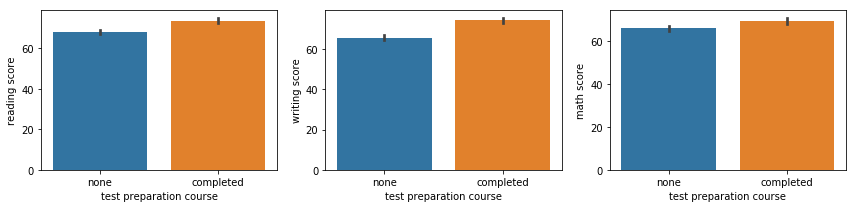

In [22]:
plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
sns.barplot(x ="test preparation course", y ="reading score", data = data)

plt.subplot(1,3,2)
sns.barplot(x ="test preparation course", y ="writing score", data = data)

plt.subplot(1,3,3)
sns.barplot(x ="test preparation course", y ="math score", data = data)

plt.tight_layout()

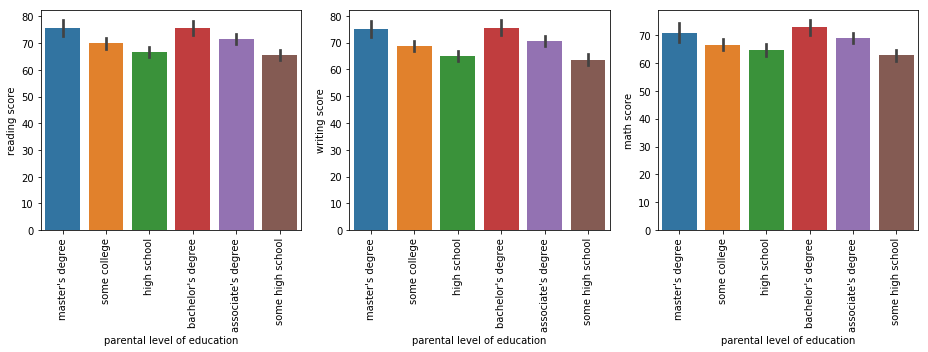

In [23]:
plt.figure(figsize=(13,5))

plt.subplot(1,3,1)
sns.barplot(x="parental level of education", y ="reading score", data = data)
plt.xticks(rotation = 90)

plt.subplot(1,3,2)
sns.barplot(x="parental level of education", y ="writing score", data = data)
plt.xticks(rotation = 90)

plt.subplot(1,3,3)
sns.barplot(x="parental level of education", y ="math score", data = data)
plt.xticks(rotation = 90)

plt.tight_layout()

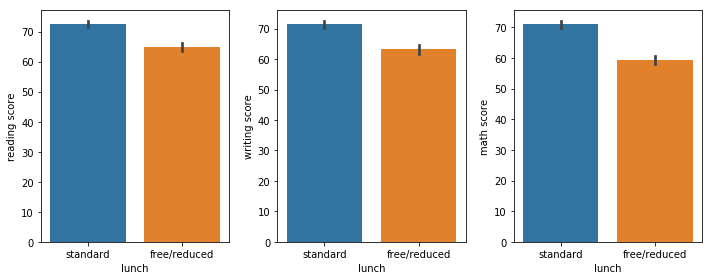

In [24]:
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
sns.barplot(x="lunch", y="reading score", data=data)

plt.subplot(1,3,2)
sns.barplot(x="lunch", y="writing score", data=data)

plt.subplot(1,3,3)
sns.barplot(x="lunch", y="math score", data=data)

plt.tight_layout()

<a id='pretprocesuiranje'></a>
Radimo kopiju originalnog DataFramea, u kojoj svaku vrijednost svake pojedine značajke zamjenjujemo odgovarajućom numeričkom vrijednošću. Primjerice, učenike muškog spola označavamo vrijednošću 1, a učenice označavamo vrijednošću 0. Rasnoj/etničkoj skupini A dodjeljujemo numeričku vrijednost 1, skupini B vrijednost 2 i tako dalje. Analogno postupamo za ostale značajke. Nakon što sve string vrijednosti zamijenimo numeričkim, koristimo se *heatmapom* iz *seaborn* paketa radi vizualizacije korelacija između pojedinih značajki.

In [25]:
pd.options.mode.chained_assignment = None
data2 = data.iloc[:, :-1].copy();

In [26]:
data2["gender"].loc[data2["gender"] == "male"] = 1
data2["gender"].loc[data2["gender"] == "female"] = 0

data2["race/ethnicity"].loc[data2["race/ethnicity"] == "group A"] = 1
data2["race/ethnicity"].loc[data2["race/ethnicity"] == "group B"] = 2
data2["race/ethnicity"].loc[data2["race/ethnicity"] == "group C"] = 3
data2["race/ethnicity"].loc[data2["race/ethnicity"] == "group D"] = 4
data2["race/ethnicity"].loc[data2["race/ethnicity"] == "group E"] = 5

data2['lunch'] = data2['lunch'].replace({'standard':1, 'free/reduced':0})

data2['test preparation course'].loc[data2['test preparation course'] == 'none'] = 0
data2['test preparation course'].loc[data2['test preparation course'] == 'completed'] = 1

data2['parental level of education'].loc[data2['parental level of education'] == 'some high school'] = 1
data2['parental level of education'].loc[data2['parental level of education'] == 'high school'] = 2
data2['parental level of education'].loc[data2['parental level of education'] == 'associate\'s degree'] = 3
data2['parental level of education'].loc[data2['parental level of education'] == 'some college'] = 4
data2['parental level of education'].loc[data2['parental level of education'] == 'bachelor\'s degree'] = 5
data2['parental level of education'].loc[data2['parental level of education'] == 'master\'s degree'] = 6

data2.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,1,1,6,1,0,85,81,82
1,1,2,4,0,0,64,61,49
2,0,5,2,0,0,48,52,53
3,1,3,5,1,1,85,85,80
4,0,3,3,1,0,74,82,79


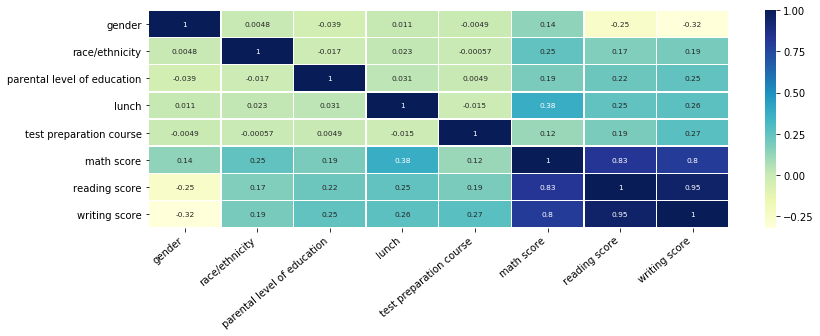

In [27]:
plt.figure(figsize=(13,4))

ax = sns.heatmap(data2.corr(), cmap="YlGnBu", annot=True, annot_kws={"size": 7.5}, linewidths=.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

Iz gornjih je grafova vidljivo sljedeće:
-  učenice u odnosu na učenike u prosjeku postižu bolje rezultate u čitanju i pisanju, ali slabije iz matematike
-  učenici iz etničke skupine E postižu u prosjeku najbolje rezultate, dok učenici iz skupine B postižu najlošije
-  učenici koji idu na pripremni tečaj te učenici koji jedu standardni (nereducirani) ručak postižu bolje rezultate (pogotovo u matematici)
-  učenici čiji roditelji imaju višu razinu obrazovanja u prosjeku postižu bolje rezultate

Zanimljivo je primujetiti i sljedeću "anomaliju": učenici čiji roditelji imaju završen magisterij postižu ponešto lošije rezultate od učenika čiji roditelji imaju završen samo "bachelor" studij.

U daljnjem dijelu analize određujemo dolaze li rezultati testova iz normalne distribucije. U tu svrhu koristimo Q-Q grafove.

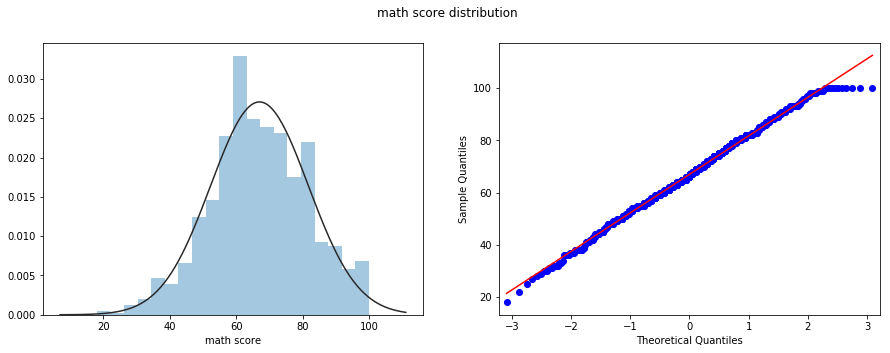

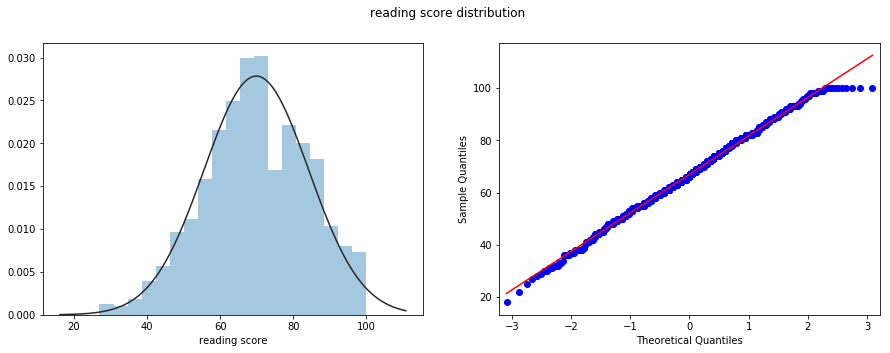

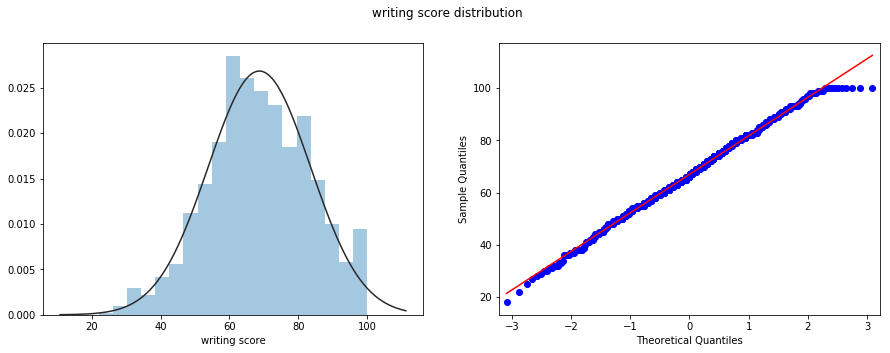

In [28]:
def graphplot(df, column):
    v1, v2 = plt.subplots(1, 2, figsize=(15,5))
    sns.distplot(df[column], fit=norm, kde=False, ax=v2[0])
    qqplot(data['math score'], line='s', ax=v2[1])
    v1.suptitle(column +' distribution')
    plt.show()

graphplot(data,'math score')
graphplot(data,'reading score')
graphplot(data,'writing score')


Na temelju QQ grafova zaključujemo da su rezultati testova iz sva 3 područja distribuirani **aproksimativno normalno uz prisustvo laganih repova**. Međutim, lagani su repovi očekivani s obzirom na to da ne postoji maksimalan (niti minimalan) broj bodova na testovima.

Provjeravamo koliko je učenika uspjelo postići rezultat veći ili jednak 90 na sva tri ispita te prikazujemo koje su vrijednosti pojedinih značajki za te učenike.

In [29]:
len(data[(data['math score'] >= 90) & (data['reading score'] >= 90) & (data['writing score'] >= 90)])

31

In [30]:
data[(data['math score'] >= 90) & (data['reading score'] >= 90) & (data['writing score'] >= 90)].sort_values(by=['total score'], ascending=False)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score
191,female,group D,some college,standard,completed,100,100,100,300
908,female,group C,bachelor's degree,standard,completed,100,100,100,300
684,female,group D,bachelor's degree,standard,none,99,100,100,299
330,male,group D,associate's degree,standard,completed,100,100,99,299
35,female,group E,bachelor's degree,standard,none,98,100,100,298
856,female,group C,master's degree,standard,completed,98,100,100,298
978,female,group E,some college,standard,none,96,100,100,296
621,female,group D,associate's degree,standard,completed,96,100,100,296
725,male,group C,bachelor's degree,standard,completed,98,98,100,296
37,female,group E,high school,standard,none,98,100,97,295


Sljedeći je korak pomoću grafova zorno prikazati odnos zastupljenosti pojedinih vrijednosti odgovarajućih značajki u skupini 10 najboljih učenika (odnosno, onih koji čiji je ukupan rezultat na ispitima među 10 najviših) i 10 najgorih učenika (onih koji čiji je ukupan rezultat na ispitima među 10 najnižih).

In [31]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score
0,male,group A,master's degree,standard,none,85,81,82,248
1,male,group B,some college,free/reduced,none,64,61,49,174
2,female,group E,high school,free/reduced,none,48,52,53,153
3,male,group C,bachelor's degree,standard,completed,85,85,80,250
4,female,group C,associate's degree,standard,none,74,82,79,235


In [32]:
best = data.sort_values(by=['total score'], ascending=False).head(10)
worst = data.sort_values(by=['total score'], ascending=False).tail(10)

Text(0,0.5,'count')

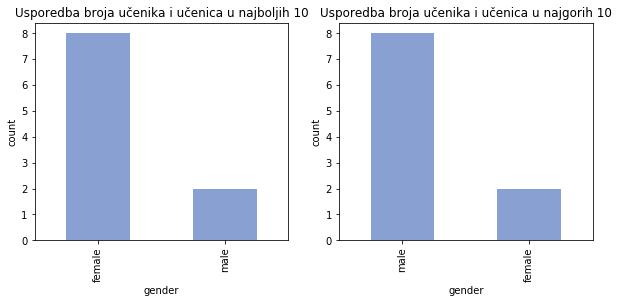

In [33]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
best['gender'].value_counts(dropna = False).plot.bar(color='#89A1D2')
plt.title('Usporedba broja učenika i učenica u najboljih 10')
plt.xlabel('gender')
plt.ylabel('count')

plt.subplot(1,2,2)
worst['gender'].value_counts(dropna = False).plot.bar(color='#89A1D2')
plt.title('Usporedba broja učenika i učenica u najgorih 10')
plt.xlabel('gender')
plt.ylabel('count')

Text(0,0.5,'count')

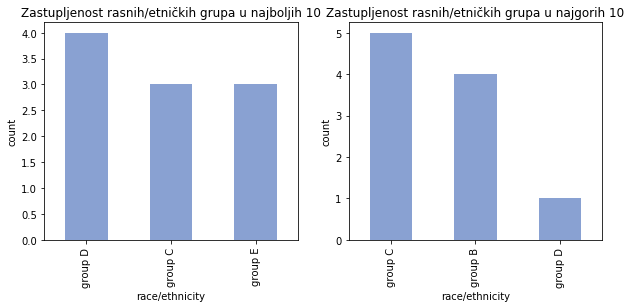

In [34]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
best['race/ethnicity'].value_counts(dropna = False).plot.bar(color='#89A1D2')
plt.title('Zastupljenost rasnih/etničkih grupa u najboljih 10')
plt.xlabel('race/ethnicity')
plt.ylabel('count')

plt.subplot(1,2,2)
worst['race/ethnicity'].value_counts(dropna = False).plot.bar(color='#89A1D2')
plt.title('Zastupljenost rasnih/etničkih grupa u najgorih 10')
plt.xlabel('race/ethnicity')
plt.ylabel('count')

Text(0,0.5,'count')

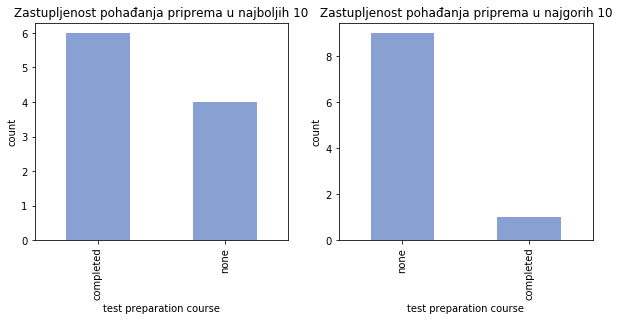

In [35]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
best['test preparation course'].value_counts(dropna = False).plot.bar(color='#89A1D2')
plt.title('Zastupljenost pohađanja priprema u najboljih 10')
plt.xlabel('test preparation course')
plt.ylabel('count')

plt.subplot(1,2,2)
worst['test preparation course'].value_counts(dropna = False).plot.bar(color='#89A1D2')
plt.title('Zastupljenost pohađanja priprema u najgorih 10')
plt.xlabel('test preparation course')
plt.ylabel('count')

Text(0,0.5,'count')

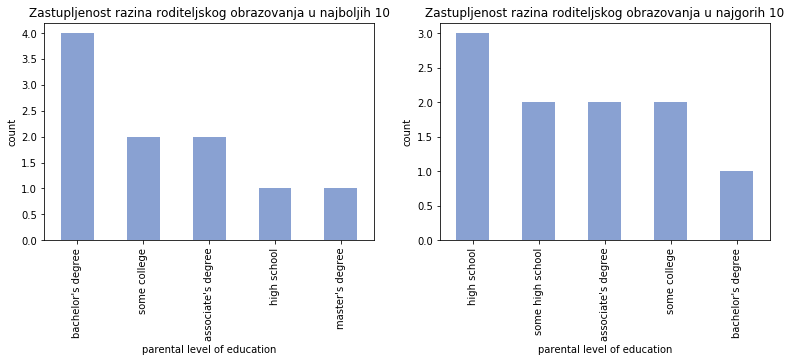

In [36]:
plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
best['parental level of education'].value_counts(dropna = False).plot.bar(color='#89A1D2')
plt.title('Zastupljenost razina roditeljskog obrazovanja u najboljih 10')
plt.xlabel('parental level of education')
plt.ylabel('count')

plt.subplot(1,2,2)
worst['parental level of education'].value_counts(dropna = False).plot.bar(color='#89A1D2')
plt.title('Zastupljenost razina roditeljskog obrazovanja u najgorih 10')
plt.xlabel('parental level of education')
plt.ylabel('count')

Text(0,0.5,'count')

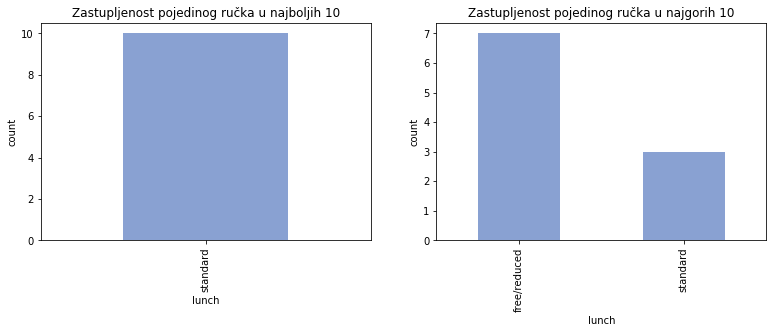

In [37]:
plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
best['lunch'].value_counts(dropna = False).plot.bar(color='#89A1D2')
plt.title('Zastupljenost pojedinog ručka u najboljih 10')
plt.xlabel('lunch')
plt.ylabel('count')

plt.subplot(1,2,2)
worst['lunch'].value_counts(dropna = False).plot.bar(color='#89A1D2')
plt.title('Zastupljenost pojedinog ručka u najgorih 10')
plt.xlabel('lunch')
plt.ylabel('count')

***

## 2. Clustering učenika

U ovom dijelu analize koristimo k-means algoritam za clustering, koji je dio nenadziranog učenja. Njime možemo identificirati određene grupe učenika sa sličnostima. Najprije pišemo funkciju koja dodjeljuje ocjene učenicima na temelju rezultata.

In [38]:
def ocjene(x):
    if x<45:
        return 1
    if x>=45 and x<60:
        return 2
    if x>=60 and x<75:
        return 3
    if x>=75 and x<90:
        return 4
    if x>=90 and x<=100:
        return 5

### 2.1. Opis k-means clustering algoritma

Neka je dan skup opservacija $({\bf x}_1, {\bf x}_2,...,{\bf x}_n)$, gdje je svaka opservacija $d$-dimenzionalan vektor. $k$-means clustering nastoji particionirati $n$ opservacija u $k$ ($\leq n$} skupova ${\bf S}=\{S_1, S_2,...,S_k\}$, tako da se minimizira suma kvadrata unutar pojedine grupe (*clustera*). Formalno, cilj je pronaći:
$$\underset{S}{\operatorname{argmin}}\displaystyle\sum_{i=1}^{k} \displaystyle\sum_{x \in S} \| {\bf x}-{\bf\mu_i} \|^2 = \underset{S}{\operatorname{argmin}}\displaystyle\sum_{i=1}^{k} |S_i|Var S_i,$$
gdje je ${\bf\mu_i}$ srednja vrijednost točaka iz $S_i$.<br><br>
Neka je početni skup $k$ srednjih vrijednosti (*means*, *centroids*) $m_1^{(1)}, m_2^{(1)},...,m_k^{(1)}$. One se mogu inicijilazirati nasumičnim odabirom $k$ vrijednosti. Algoritam koristi tehniku iterativnog rafiniranja, i to ponavljanjem sljedeća dva koraka:<br><br>
&nbsp;&nbsp;&nbsp; **Assignment step**: Svaku opservaciju dodjeljujemo grupi (*clusteru*) sa srednjom vrijednosti za koju je euklidska udaljenost najmanja (intuitivno, grupi čija je srednja vrijednost "najbliža"): <br>
&nbsp;&nbsp;&nbsp; $S_i^{(t)} = \{x_p : \|x_p-m_i^{(t)}\|^2 \leq \|x_p-m_j^{(t)}\|^2 \forall j, 1 \leq j \leq k\}$,<br>
&nbsp;&nbsp;&nbsp;gdje je svaki $x_p$ dodijeljen točno jednom $S^{(t)}$, čak i kada može biti dodijeljen dvoje ili više njih.<br><br>
&nbsp;&nbsp;&nbsp; **Update step**: Računamo nove *means* (*centroids*) opseravacija u novim grupama (*clusters*):<br>
&nbsp;&nbsp;&nbsp;$m_i^{(t+1)}=\frac{1}{|S_i^{(t)}|}\displaystyle\sum_{x_j \in S_i^{(t)}}x_j$ <br><br>
Algoritam je konvergirao kada se dogodila iteracija bez promjena u dodjeljivanju. Konvergencija je zorno prikazana na donjoj animaciji:

<img src="https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif" width="350" height="350" />

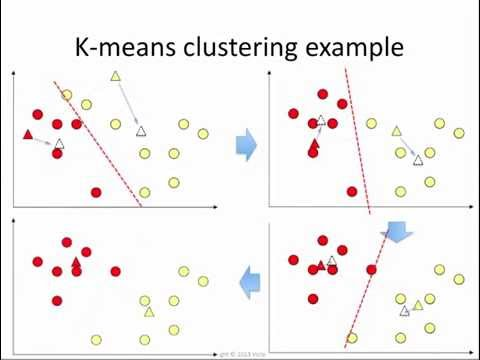

In [39]:
YouTubeVideo("_aWzGGNrcic")

*Video 2: Objašnjenje k-means algoritma za clustering*

In [40]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score
0,male,group A,master's degree,standard,none,85,81,82,248
1,male,group B,some college,free/reduced,none,64,61,49,174
2,female,group E,high school,free/reduced,none,48,52,53,153
3,male,group C,bachelor's degree,standard,completed,85,85,80,250
4,female,group C,associate's degree,standard,none,74,82,79,235


In [41]:
average_score = data.iloc[:,-4:-1]
x3 =  data.iloc[:,-4:-1]
onehot1=OneHotEncoder()
average_score=onehot1.fit_transform(average_score.applymap(ocjene)).toarray()

In [42]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 5, init = "k-means++")
y_kmeans = kmeans.fit_predict(average_score)
x3["cluster"] = y_kmeans

<IPython.core.display.Javascript object>


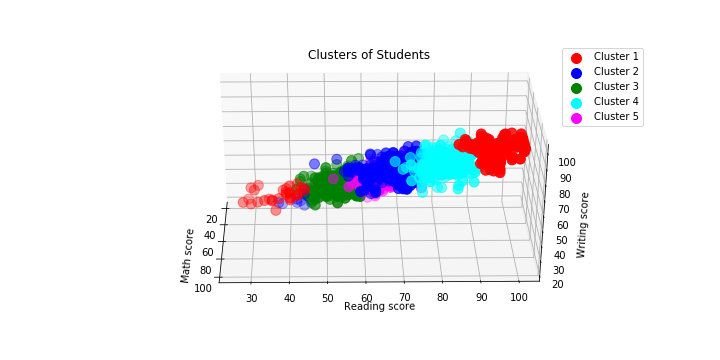

In [63]:
# Vizualiziranje grupa (clustera)
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize = (10, 5))
ax11 = fig.add_subplot(111, projection='3d')
ax11.scatter((x3[x3.cluster == 0])["math score"].values, (x3[x3.cluster == 0])["reading score"].values, (x3[x3.cluster == 0])["writing score"].values, s = 100, c = 'red', label = 'Cluster 1')
ax11.scatter((x3[x3.cluster == 1])["math score"].values, (x3[x3.cluster == 1])["reading score"].values, (x3[x3.cluster == 1])["writing score"].values, s = 100, c = 'blue', label = 'Cluster 2')
ax11.scatter((x3[x3.cluster == 2])["math score"].values, (x3[x3.cluster == 2])["reading score"].values, (x3[x3.cluster == 2])["writing score"].values, s = 100, c = 'green', label = 'Cluster 3')
ax11.scatter((x3[x3.cluster == 3])["math score"].values, (x3[x3.cluster == 3])["reading score"].values, (x3[x3.cluster == 3])["writing score"].values, s = 100, c = 'cyan', label = 'Cluster 4')
ax11.scatter((x3[x3.cluster == 4])["math score"].values, (x3[x3.cluster == 4])["reading score"].values, (x3[x3.cluster == 4])["writing score"].values, s = 100, c = 'magenta', label = 'Cluster 5')
ax11.set_title("Clusters of Students")
ax11.set_xlabel("Math score")
ax11.set_ylabel("Reading score")
ax11.set_zlabel("Writing score")
ax11.legend()

for angle in range(0, 360):
    ax11.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
plt.show()

## 3. Prediktivna analitika

U nastavku radimo na prediktivnoj analitici - **predviđanju varijable "total score"** na temelju sljedećih značajki: spol, razina obrazovanja roditelja, tip ručka, pohađanje pripremnog tečaja te rasna/etnička skupina. Korist ćemo jednostavnije tehnike poput linearne regresije i stabala odluke, a potom i ponešto složeniju metodu baziranu na ansamblima - *random forests* te neuronske mreže. Za početak učitavamo sve potrebne pakete i funkcije.

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import metrics

Dio pretprocesuiranja podataka obavljen je još <a href='#pretprocesuiranje'>prije</a> pa u nastavku koristimo djelomično pretprocesuirani DataFrame *data2*.

In [45]:
data2.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,1,1,6,1,0,85,81,82
1,1,2,4,0,0,64,61,49
2,0,5,2,0,0,48,52,53
3,1,3,5,1,1,85,85,80
4,0,3,3,1,0,74,82,79


Dodajemo stupac *total score* koji predstavlja sumu tri pojedinačna rezultata te koji ćemo koristiti kao zavisnu varijablu/ciljnu funkciju.

In [46]:
data2["total score"]=data2["math score"]+data2["reading score"]+data2["writing score"]
data2.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score
0,1,1,6,1,0,85,81,82,248
1,1,2,4,0,0,64,61,49,174
2,0,5,2,0,0,48,52,53,153
3,1,3,5,1,1,85,85,80,250
4,0,3,3,1,0,74,82,79,235


Dodatno, primijetimo da kategorička varijabla *race/ethnicity* poprima jednu od $5$ različitih vrijednosti, odnosno može se svrstati u jednu od 5 grupa. S obzirom na to da priroda podataka ne dopušta interpretabilan *ordering*, radimo one-hot encoding kao dio pretprocesuiranja. Naime, kategoričke varijable na čijem skupu vrijednosti ne postoji smislen uređaj nije dovoljno samo konvertirati u numeričke vrijednosti. Ako ih konvertiramo u numeričke vrijednosti i prepustimo algoritmu strojnog učenja da sam pretpostavi prirodan uređaj, možemo dobiti loše i neočekivane rezultate.
One-hot encoding proces je kojim se kategoričke varijable kovertiraju u oblik koji je pogodan za postizanje dobrih rezultata algoritama strojnog učenja. Svaka vrijednost numerički reprezentirane varijable zamjenjuje se jedinstvenom binarnom vrijednošću, i to na način objašnjen u sljedećem videu:

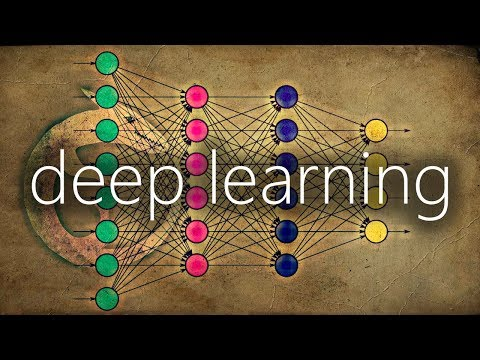

In [47]:
YouTubeVideo("v_4KWmkwmsU")

*Video 3: Objašnjenje one-hot encodinga*

In [48]:
one_hot = pd.get_dummies(data2["race/ethnicity"])
data2 = data2.join(one_hot)
data2.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score,1,2,3,4,5
0,1,1,6,1,0,85,81,82,248,1,0,0,0,0
1,1,2,4,0,0,64,61,49,174,0,1,0,0,0
2,0,5,2,0,0,48,52,53,153,0,0,0,0,1
3,1,3,5,1,1,85,85,80,250,0,0,1,0,0
4,0,3,3,1,0,74,82,79,235,0,0,1,0,0


Također, dodajemo dodatni stupac koji sadrži informaciju o tome je li određeni učenik prošao testove. Kažemo da je učenik prošao testove ukoliko je varijabla *total score* veća ili jednaka 140. 

In [49]:
def pass_or_not(x):
    if x<140:
        return 0
    else:
        return 1

In [50]:
data2["pass"] = data2["total score"].apply(pass_or_not)

In [51]:
data2.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score,1,2,3,4,5,pass
0,1,1,6,1,0,85,81,82,248,1,0,0,0,0,1
1,1,2,4,0,0,64,61,49,174,0,1,0,0,0,1
2,0,5,2,0,0,48,52,53,153,0,0,0,0,1,1
3,1,3,5,1,1,85,85,80,250,0,0,1,0,0,1
4,0,3,3,1,0,74,82,79,235,0,0,1,0,0,1


Sada konačno možemo krenuti s primjenom prediktivnih algoritama. 

### 3.1. Linearna regresija

Za početak, koristimo linearnu regresiju, pri čemu su  spol, razina obrazovanja roditelja, tip ručka, pohađanje pripremnog tečaja te rasna/etnička skupina nezavisne, a *total score* zavisna varijabla. Podatke particioniramo u skup za treniranje i skup za testiranje. Za potrebe evaluacije modela koristimo *10-Fold cross validation*.

#### 3.1.1. Općenito o linearnoj regresiji

Neka je dan ulazni vektor $d$ varijabli (eng. *attributes*, *features*) ${\bf x}=(x_1, x_2,...,x_d)$. Izlazna ili ciljna varijabla (eng. *target variable*) neka je $y$. Primjer za učenje (eng. *training example*) uređen je par $({\bf x}, y)$, a $D = \{({\bf x_i},y_i) : i=1,...,n\}$ je skup primjera za učenje (eng. *training set*).<br>
$f : X \to Y$ linearna je kombinacija ulaznih varijabli: <br>
$$f(x) = w_0 + w_1 x_1 + w_2 x_2 +...+ w_d x_d = w_0 + \displaystyle\sum_{i=1}^{d}w_i x_i$, gdje su $w_0, w_1,...,w_d$$ parametri modela (težine).<br>
Radi pojednostavljenja, možemo dodati još jednu (konstantnu) varijablu:
$f(x) = w_0 x_0 + w_1 x_1 + w_2 x_2 +...+ w_d x_d = {\bf w^T x}$.
<img src="linearna_regresija.png" width="350" height="350" />
*Funkcija greške* mjeri koliko predikcije odstupaju od željenih vrijednosti $y$, a definiramo je kao srednju kvadratnu pogrešku (MSE - *Mean Squared Error*): <br>
$$J({\bf w}) = \frac{1}{n}\displaystyle\sum_{i=1}^{n}(y_i - f({\bf x_i}))^2 = \frac{1}{n}\displaystyle\sum_{i=1}^{n}(y_i - {\bf w^T x_i})^2$$. <br>
Za optimalne težine ${\bf w}$ vrijedi: <br>
$$\frac{\partial J({\bf w})}{\partial {\bf w_j}} = - \frac{2}{n}\displaystyle\sum_{i=1}^{n}(y_i - w_0 x_{i,0} - w_1 x_{i,1} -...-w_d x_{i,d})x_{i,j}=0$$ <br>
pa se rješavanje linearnog regresijskog problema svodi upravo na rješavanje sustava linearnih jednadžbi s $(d+1)$ nepoznanicom, gdje je $j$-ta komponenta: <br>
$$w_0\displaystyle\sum_{i=1}^{n}x_{i,0}x_{i,j}+w_1\displaystyle\sum_{i=1}^{n}x_{i,1}x_{i,j}+...+w_j\displaystyle\sum_{i=1}^{n}x_{i,0}x_{i,j}+...+w_d\displaystyle\sum_{i=1}^{n}x_{i,d}x_{i,j} = \displaystyle\sum_{i=1}^{n}y_i x_{i,j}$$.

#### 3.1.2. k-struka unakrsna validacija (k-fold cross validation)

k-struka unakrsna validacija (*k-fold cross validation*) tehnika je probira koja funkcionira na sljedeći način:<br>
&nbsp;&nbsp;&nbsp;a) Slučajno raaspoređujemo primjere za učenje (eng. *training examples*) u $k$ odvojenih skupova $T_i, i=1,...,k$ <br>
&nbsp;&nbsp;&nbsp;b) Za $i=1$ do $k$: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1) Koristi $T_i$ kao testni skup, a ostale podatke ($T_m$ t.d. $m \neq i$) iskoristi za učenje modela <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2) Na testnom skupu $T_i$ izračunaj grešku $L_m$ modela $h_m$ <br>
&nbsp;&nbsp;&nbsp;c) Izračunaj prosječnu grešku za svih k modela: <br>
$$\overline{L}_{k-fold}=\frac{1}{k}\displaystyle\sum_{m=1}^{k}L_m$$.
<img src="kfoldcrossval.png" width="600" height="600" />

In [52]:
X = data2[["gender", "parental level of education", "lunch", "test preparation course", 1,2,3,4,5]].values
y = data2["total score"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [53]:
kfold1 = model_selection.KFold(n_splits=10)
regression1 = LinearRegression()
results = model_selection.cross_val_score(regression1, X, y, cv=kfold1, scoring="r2")
regression1.fit(X_train,y_train)
regression1_predictions = regression1.predict(X_test)
print('Koeficijenti su: \n', regression1.coef_)

Koeficijenti su: 
 [-12.76226219   6.11287654  23.91475185  19.35140501  -5.36305524
 -10.24473085  -5.80522341   3.07228278  18.34072673]


#### 3.1.3. R$^2$

Koeficijent determinacije (eng. *coefficient of determination*) ili $R^2$ proporcija je varijance zavisne varijable koja se može predvidjeti na temelju nezavisnih varijabli. <br>
Neka je dano $n$ vrijednosti $y_1, y_2,...y_n$ i neka svakoj odgovara predviđena vrijednost $f_1, f_2,...,f_n$. <br>
Definiramo reziduale kao $e_i = y_i - f_i$. <br>
Ako je $\overline{y}$ srednja vrijednost podataka: <br>
$$\overline{y} = \frac{1}{n}\displaystyle\sum_{i=1}^{n}y_i,$$ <br>
tada se varijabilnost podataka može mjeriti korištenjem sljedeće tri formule: <br>
$$SS_{tot} = \displaystyle\sum_{i}(y_i-\overline{y})^2,$$
$$SS_{reg} = \displaystyle\sum_{i}(f_i-\overline{y})^2,$$ 
$$SS_{res} = \displaystyle\sum_{i}(y_i-f_i)^2 = \displaystyle\sum_{i}e_i^2.$$
Koeficijent determinacije definira se kao:
$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

In [54]:
print("Metrika R^2 iznosi: ", r2_score(y_test,regression1_predictions))
print('Root mean square error:', np.sqrt(metrics.mean_squared_error(y_test, regression1_predictions)))

Metrika R^2 iznosi:  0.3147003927950702
Root mean square error: 35.361395132839384


Primjećujemo da je $R^2$ metrika oko 0.3, dakle nezavisne varijable objašnjavaju oko 30% varijance zavisne varijable.

### 3.2. Random forests

Nakon linearne regresije, u svrhu prediktivne analitike koristit ćemo metodu slučajne šume (*random forests*).

*Random forests* algoritam kombinira ansambl metodu strojnog učenja *bagging* sa slučajnim odabirom podskupa varijabli (atributa). *Random forests* gradi stabla odlučivanja iz *bootstrap* uzorka skupa za učenje. Za razliku od biranja najboljeg atributa za split između svih atributa kod stabala odlučivanja, najbolji se atribut za split izabire između $k$ slučajno odabranih atributa. Tipična vrijednost $k$ za *random forests* iznosi $\sqrt d$, gdje je $d$ broj atributa. Što je $k$ manji, veća je redukcija varijance, ali je i veći bias.

#### 3.2.1. Bagging

Uz dani skup za učenje $X$ (kardinalnosti $n$) s vrijednostima ciljne varijable $Y$, *bagging* iterativno ($B$ puta) odabire nasumičan uzorak s ponavljanjem iz skupa za učenje i na temelju njega gradi model (stablo):<br>
&nbsp;&nbsp;Za $b = 1,...B:$<br>
&nbsp;&nbsp;&nbsp;&nbsp;1. Uzorkuj s ponavljanjem $n$ primjera za učenje iz $X, Y$; nazovi ih $X_b, Y_b$<br>
&nbsp;&nbsp;&nbsp;&nbsp;2. Treniraj klasifikacijsko ili regresijsko stablo $f_b$ na $X_b, Y_b$.<br>
Nakon treniranja, predikcije za nove primjere $x'$ možemo raditi usrednjavanjem predikcija svih individualnih regresijskih stabala na $x'$:
$$\hat{f} = \frac{1}{B}\displaystyle\sum_{b=1}^{B}f_b(x')$$ 
ili većinskim glasanjem u slučaju klasifikacijskih stabala.
<img src="randomforest.png" width="600" height="600" />

In [55]:
randomforest1 = RandomForestRegressor(n_estimators = 80, max_depth=20, random_state = 10)
randomforest1.fit(X_train,y_train)
randomforest1_predictions = randomforest1.predict(X_test) 

# R^2 Score
print("Metrika R^2 iznosi: ", r2_score(y_test,randomforest1_predictions))

Metrika R^2 iznosi:  0.12941737276556986


U ovom slučaju metrika $R^2$ iznosi oko 0.18, odnosno postižemo manju prediktivnu moć nego korištenjem linearne regresije.

### 3.3. Neuronske mreže

U posljednjem dijelu ove podatkovne analize koristimo neuronsku mrežu za predikciju varijable *total score*. Neuronske mreže jedan su od danas najpopularnijih metoda strojnog učenja koji može modelirati **složene nelinearne veze** zahvaljujući nelinearnosti svoje aktivacijske funkcije (najčešće ReLu, sigmoid ili tanh). Iako su neuronske mreže izrazito moćan alat koji je donio (te i dalje donosi) svojevrsnu revoluciju unutar raznih industrija, ne predstavljaju "sveti gral" strojnog učenja obzirom da njihovi nedostaci uključuju **sklonost overfittingu i potrebu za velikim datasetovima** u slučaju neuronskih mreža s mnogo neurona. Započinjemo određivanjem oblika varijabli *X_train* i *y_train*

In [56]:
X_train.shape

(700, 9)

Zatim definiramo model uporabom libraryja Keras pri čemu Tensorflow koristimo kao backend. Keras je iznimno često korišteni API visoke razine za treniranje i testiranje neuronskim mreža, baziran u Pythonu. Jedna od glavnih prednosti Kerasa je njegova iznimna jednostavnost i modularnost. Konkretno, za stvaranje samog modela koristimo Kerasov __[sequential model](https://keras.io/models/sequential/)__ pomoću kojeg neuronske mreže slažemo sloj po sloj po analogiji Lego kockica. U našem slučaju, obzirom da je podatkovni skup relativno malen (1000 opservacija), korist ćemo relativno **malenu neuronsku mrežu s dva skrivena sloja**, svaki sa 64 nerona. Svi layeri su *dense* tipa te ne koristimo posebne konvolucijske ili *recurrent* slojeve. Obzirom da je neuronska mreža relativno malena ne koristimo dodatne regularizacijske tehnike poput *dropouta* ili L1/L2 regularizacije. Korištenje neuronske mreže s relativno malenim brojem neurona jedna je od najjednostavnijih metoda za ublažavanje problema *overfittinga* - definitivno centralnog (a možda i jedinog pravog) problema strojnog učenja.

In [57]:
!pip install --user tensorflow

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [58]:
!pip install --user keras

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [59]:
from keras import models
from keras import layers
def buildmodel():
    network = models.Sequential()
    network.add(layers.Dense(64, activation='relu', input_shape=(9,)))
    network.add(layers.Dense(64, activation='relu'))
    network.add(layers.Dense(1))
    network.compile(optimizer='rmsprop', loss='mse', metrics = ["mae"])
    return network

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Zatim gradimo model pozivanjem naše *custom* funkcije buildmodel te prilagođavamo (*fittamo*) model podatkovnom skupu. Pritom kao broj epoha uzimam 100, a veličinu *batchea* postavljamo na 16.

In [60]:
model1 = buildmodel()
model1.fit(X_train, y_train, epochs=100, batch_size=16)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
700/700 [==============================] - 0s 221us/step - loss: 41779.4326 - mean_absolute_error: 200.1893
Epoch 2/100
700/700 [==============================] - 0s 46us/step - loss: 34966.8129 - mean_absolute_error: 182.2960
Epoch 3/100
700/700 [==============================] - 0s 40us/step - loss: 22999.3004 - mean_absolute_error: 145.5464
Epoch 4/100
700/700 [==============================] - 0s 42us/step - loss: 10042.5555 - mean_absolute_error: 89.8814
Epoch 5/100
700/700 [==============================] - 0s 41us/step - loss: 3675.5698 - mean_absolute_error: 49.5270
Epoch 6/100
700/700 [==============================] - 0s 41us/step - loss: 2967.5206 - mean_absolute_error: 44.2027
Epoch 7/100
700/700 [==============================] - 0s 47us/step - loss: 2697.9542 - mean_absolute_error: 42.0145
Epoch 8/100
700/700 [==============================] 

700/700 [==============================] - 0s 34us/step - loss: 1291.6915 - mean_absolute_error: 29.1395
Epoch 66/100
700/700 [==============================] - 0s 43us/step - loss: 1281.5444 - mean_absolute_error: 28.9767
Epoch 67/100
700/700 [==============================] - 0s 39us/step - loss: 1293.6907 - mean_absolute_error: 29.1687
Epoch 68/100
700/700 [==============================] - 0s 51us/step - loss: 1285.7139 - mean_absolute_error: 29.0753
Epoch 69/100
700/700 [==============================] - 0s 42us/step - loss: 1288.0213 - mean_absolute_error: 28.9930
Epoch 70/100
700/700 [==============================] - 0s 45us/step - loss: 1292.4891 - mean_absolute_error: 29.1071
Epoch 71/100
700/700 [==============================] - 0s 38us/step - loss: 1289.2575 - mean_absolute_error: 29.0423
Epoch 72/100
700/700 [==============================] - 0s 49us/step - loss: 1291.0055 - mean_absolute_error: 29.1856
Epoch 73/100
700/700 [==============================] - 0s 43us/step 

Na poslijetku vršimo evaluaciju modela korištenjem MSE i RMSE:

In [61]:
test_mse_score, test_mae_score = model1.evaluate(X_test, y_test)

300/300 [==============================] - 0s 83us/step


In [62]:
print("Mean square error: ", test_mse_score)
print('Root mean square error:', np.sqrt(test_mse_score))

Mean square error:  1279.832390950521
Root mean square error: 35.774745155633475


Zaključujemo kako je po pitanju prediktivne moći naša neuronska mreža postiže slične rezultate kao obična linearna regresija, odnosno donosi podjednako dobru generalizaciju. Dodatnim eksperimentiranjem s hiperparametrima (mijenjanje broja neurona u pojedinom sloju, dodavanje dodatnih skrivenih slojeva) te regularizacijom vjerojatno je moguće dodatno unaprijediti prediktivnu moć modela.